In [3]:
import np as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.6f}".format

In [26]:
train_df = pd.read_csv(
    filepath_or_buffer=r'C:\Projects\Crosstalk\Machine_Learning\Data\2024-09-05_14-55\large_data.csv')
test_df = pd.read_csv(filepath_or_buffer="C:\Projects\Crosstalk\Machine_Learning\Data/2024-09-05_14-55/test.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/with_decay/no_j/no_j_1000.csv")

# train_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100000.csv")
# test_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_100.csv")
# validation_df = pd.read_csv(filepath_or_buffer="Z_with_correlations/all_expectation_values_10000.csv")
train_df.head()
print(len(train_df))

11000


In [ ]:
class TrigonometricLayer(tf.keras.layers.Layer):
    def __init__(self, t, num_measurements, **kwargs):
        super(TrigonometricLayer, self).__init__(**kwargs)
        self.t = t  # Time at which measurements are taken
        self.num_measurements = num_measurements  # Number of measurement functions

    def build(self, input_shape):
        # Initialize trainable parameters

        self.trig_weights = self.add_weight(
            name='trig_weights',
            shape=(20, 8),
            initializer=tf.random_uniform_initializer(minval=0.0, maxval=1.0),
            trainable=True
        )

        super(TrigonometricLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute each measurement function based on trainable parameters
        w0, w1, j, a1, a2 = inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3], inputs[:, 4]

        x1 = tf.cos(w0 * self.t) * tf.exp(- a1 * self.t)
        x2 = tf.cos(w1 * self.t) * tf.exp(- a1 * self.t)
        x3 = tf.cos(j * self.t) * tf.exp(- a1 * self.t)
        x4 = tf.sin(w0 * self.t) * tf.exp(- a1 * self.t)
        x5 = tf.sin(w1 * self.t) * tf.exp(- a1 * self.t)
        x6 = tf.sin(j * self.t) * tf.exp(- a1 * self.t)
        x7 = tf.cos((w0 + w1) * self.t) * tf.exp(- a1 * self.t)
        x8 = tf.cos((w0 + j) * self.t) * tf.exp(- a1 * self.t)
        x9 = tf.cos((w1 + j) * self.t) * tf.exp(- a1 * self.t)
        x10 = tf.cos((w1 + j + w0) * self.t) * tf.exp(- a1 * self.t)

        x11 = tf.cos(w0 * self.t) * tf.exp(- a2 * self.t)
        x12 = tf.cos(w1 * self.t) * tf.exp(- a2 * self.t)
        x13 = tf.cos(j * self.t) * tf.exp(- a2 * self.t)
        x14 = tf.sin(w0 * self.t) * tf.exp(- a2 * self.t)
        x15 = tf.sin(w1 * self.t) * tf.exp(- a2 * self.t)
        x16 = tf.sin(j * self.t) * tf.exp(- a2 * self.t)
        x17 = tf.cos((w0 + w1) * self.t) * tf.exp(- a2 * self.t)
        x18 = tf.cos((w0 + j) * self.t) * tf.exp(- a2 * self.t)
        x19 = tf.cos((w1 + j) * self.t) * tf.exp(- a2 * self.t)
        x20 = tf.cos((w1 + j + w0) * self.t) * tf.exp(- a2 * self.t)

        trig_combinations = tf.stack([
            x1, x2, x3, x4, x5, x6, x7, x8, x9, x10,
            x11, x12, x13, x14, x15, x16, x17, x18, x19, x20
        ], axis=-1)

        outputs = tf.matmul(trig_combinations, self.trig_weights)  # Shape: (1, num_features)

        return outputs

In [27]:
from tensorflow.python.keras.regularizers import L2, L1
import Symbolic.symbolic_evolution as symbolic_evolution

import re

# symbolic_exp = symbolic_evolution.get_expectation_values_exp(2, neighbors=0)
# symbolic_exp.reverse()

import tensorflow as tf

import tensorflow as tf

learning_rate = 0.0001
epochs = 500
batch_size = 100

# Get all column names as a list
keys = train_df.keys().tolist()
# output_keys = ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]
output_keys = ["decay_0", "decay_1", "decay_2", "decay_3", "W_0", "W_1", "W_2", "W_3", "J_0", "J_1", "J_2"]

keys = [key for key in keys if key not in output_keys]
inputs = {key: tf.keras.layers.Input(shape=(1,), name=key) for key in keys}
concatenated_inputs = tf.keras.layers.concatenate(list(inputs.values()))

# Prepare data for training
train_features = {key: train_df[key] for key in inputs}
train_labels = train_df[output_keys]

# Similarly prepare test and validation data
test_features = {key: test_df[key] for key in inputs}
test_labels = test_df[output_keys]


#
# validation_features = {key: validation_df[key] for key in inputs}
# validation_labels = validation_df[output_keys]


def build_model(input_layer, num_layers, nodes_per_layer=None, default_nodes=64):
    # If no list of nodes is provided, use the default number of nodes for all layers
    if nodes_per_layer is None:
        nodes_per_layer = [default_nodes] * num_layers

    # Check if nodes_per_layer has the correct number of layers
    assert len(nodes_per_layer) == num_layers, "Length of nodes_per_layer must match num_layers"

    # Build the hidden layers dynamically
    hidden_layer = input_layer
    for i in range(num_layers):
        hidden_layer = tf.keras.layers.Dense(nodes_per_layer[i], activation='relu')(hidden_layer)

    # Output layer (Assuming len(output_keys) is predefined)
    output = tf.keras.layers.Dense(len(output_keys))(hidden_layer)

    return output


nodes_per_layer = [32, 64, 64, 64, 64, 64, 64, 64, 8]  # Optional, can be None
output = build_model(concatenated_inputs, len(nodes_per_layer), nodes_per_layer)

# hidden_layer_1 = tf.keras.layers.Dense(20, activation='relu')(concatenated_inputs)
# hidden_layer_1 = tf.keras.layers.Dense(32, activation='relu')(concatenated_inputs)
# hidden_layer_1 = tf.keras.layers.Dense(32, activation='relu')(hidden_layer_1)
# hidden_layer_1 = tf.keras.layers.Dense(32, activation='relu')(hidden_layer_1)
# hidden_layer_1 = tf.keras.layers.Dense(32, activation='relu')(hidden_layer_1)
# hidden_layer_1 = tf.keras.layers.Dense(32, activation='relu')(hidden_layer_1)
#
# output = tf.keras.layers.Dense(len(output_keys), activation='relu')(hidden_layer_1)
# output = TrigonometricLayer(1, 1)(hidden_layer_1)

# num_layers = 15

model = tf.keras.Model(inputs=inputs, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_absolute_error')
# train_features_tensor = tf.convert_to_tensor(train_features.values, dtype=tf.float32)

# model.compile(optimizer=optimizer,
#               loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, train_features_tensor))


In [28]:

# Train the model
# history = model.fit(train_features, train_labels, validation_data=(validation_features, validation_labels), epochs=epochs, batch_size=batch_size);
history = model.fit(train_features, train_labels, validation_split=0.2, epochs=epochs, batch_size=batch_size)

# Evaluate the model
model.evaluate(test_features, test_labels)

# Extract loss and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6383 - val_loss: 0.5912
Epoch 2/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5808 - val_loss: 0.5689
Epoch 3/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5532 - val_loss: 0.5352
Epoch 4/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5206 - val_loss: 0.5164
Epoch 5/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5054 - val_loss: 0.4982
Epoch 6/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4850 - val_loss: 0.4825
Epoch 7/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4736 - val_loss: 0.4736
Epoch 8/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4649 - val_loss: 0.4649
Epoch 9/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4555 - val_loss: 0.4557
Epoch 10/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4450 - val_loss: 0.4434
Epoch 11/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4351 - val_loss: 0.4321
Epoch 12/500
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4

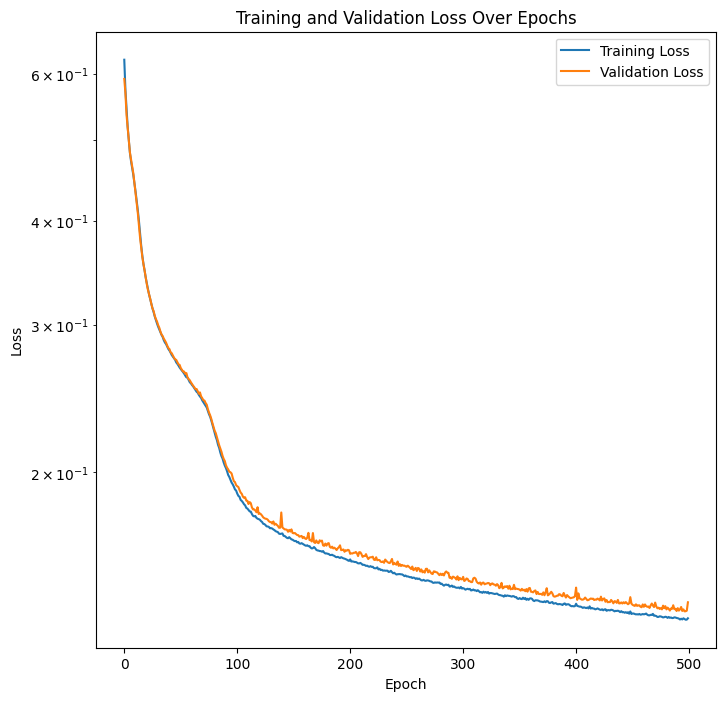

In [30]:
epochs_range = range(epochs)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
#plt.xlim([1,epochs])
#plt.ylim([0,2])
plt.semilogy()
plt.show()

In [38]:
import numpy as np
import estimator

new_data = pd.read_csv("C:\Projects\Crosstalk\Machine_Learning\Data/2024-09-05_14-55/test.csv")
first_line = new_data.iloc[0]
# correct_output = first_line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array
correct_output = first_line[["decay_0", "decay_1", "decay_2", "decay_3", "W_0", "W_1", "W_2", "W_3", "J_0", "J_1", "J_2"]].array

#input_data = {key: [first_line[key]] for key in inputs}
input_data = {key: np.array([first_line[key]]) for key in inputs}
predictions = model.predict(input_data)
print("Predicted values: ", predictions[0][0])
print("Correct values: ", correct_output)
print("the mean squared error is: ", 0.3 * np.linalg.norm(predictions[0] - correct_output) ** 2)
error = estimator.percent_error(predictions[0], correct_output)
print("The percent error is: ", error * 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted values:  0.39285168
Correct values:  <PandasArray>
[0.5613098613948054, 0.3129869440879494, 0.3202191835135491,
 0.3820119073561902, -1.010760922101796, 1.5567504180474685,
 0.8112686657491521, 0.7505619997996814, 0.3124498212871597,
 -0.202262382580408,  0.836599569802191]
Length: 11, dtype: float64
the mean squared error is:  0.21893099808494115
The percent error is:  46.092195693542706


In [39]:
error = []
for i in range(len(new_data)):
    line = new_data.iloc[i]

    # correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array
    correct_output = line[["decay_0", "decay_1", "decay_2", "decay_3", "W_0", "W_1", "W_2", "W_3", "J_0", "J_1", "J_2"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)
    error.append(estimator.percent_error(predictions[0], correct_output))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [40]:
print("The mean percent error is: ", np.mean(error) * 100)

The mean percent error is:  50.808677877805096


In [125]:
error_dict = {key: [] for key in ['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]}

for i in range(len(new_data)):
    line = new_data.iloc[i]

    correct_output = line[['decay_0', 'decay_1', 'W_0', 'W_1', "J_0"]].array

    input_data = {key: np.array([line[key]]) for key in inputs}
    predictions = model.predict(input_data)

    # Calculate the percent error for each output key and append it to the respective list
    for j, key in enumerate(error_dict.keys()):
        error_dict[key].append(estimator.percent_error(predictions[0][0][j], correct_output[j]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [126]:
import pandas as pd

# Convert the error dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)

# Calculate the mean of each error
mean_errors = error_df.mean()

# Display the results
for key, value in mean_errors.items():
    print(f"The mean error for {key} is: {value * 100} precent")

print("total error is: ", mean_errors.mean() * 100)

The mean error for decay_0 is: 21.14048892259431 precent
The mean error for decay_1 is: 29.513848007879584 precent
The mean error for W_0 is: 408.22536167818157 precent
The mean error for W_1 is: 32.036623575115335 precent
The mean error for J_0 is: 8072.218115692011 precent
total error is:  1712.6268875751566


In [13]:

print(custom_loss(predictions[0], correct_output))
a = custom_loss(predictions[0], correct_output)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Mul] name: 